# Project 4: Deep-Convolutional Generative Adversarial Networks 
Dataset: BIRDS-450 Classification Dataset 

In [22]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch 
import torch.nn as nn 
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision 
from typing import Tuple, Any
from torchvision import datasets, models
import torchvision.transforms as T
import random
import cv2
from PIL import Image
import os

# **Section 1: The Data**

In [23]:
 base_path = "/content"
 train_path = base_path + "/train"

In [ ]:
!unzip /content/drive/MyDrive/CS231N/Projects_The_good_stuff/P4GANs/birds_dataset.zip

In [25]:
category_map = {}
train_count = 0
train_images = []

for idx, entry in enumerate(os.listdir(train_path)):
  
  if os.path.isdir(os.path.join(train_path, entry)):
    category_map[entry] = idx
    train_count+= len(os.listdir(train_path+"/"+entry))
  
    for img in os.listdir(train_path+"/"+entry):
    
      train_images.append(train_path+"/"+entry+"/"+img)

print(train_count) #verify number of training images
print(train_images[0]) #Verify what the paths look like 

70626
/content/train/CAPE LONGCLAW/126.jpg


In [26]:
class birds_dataset(Dataset):
  
  def __init__(self, images, birds_classes, transform):
    
    super().__init__()
    self.images = images 
    self.class_map = birds_classes 
    self.transforms = transform
  
  def __getitem__(self, index):
    
    img_path = self.images[index]
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    
    image = Image.fromarray(image.astype(np.uint8))
    
    label = img_path.split("/")[-2]
    label = self.class_map[label]   

    if self.transforms:
      image = self.transforms(image)
    
    return image, label 
  
  def __len__(self):
    
    return len(self.images)

In [27]:
train_transform = T.Compose([T.Resize((128, 128))])
train_set = birds_dataset(train_images, category_map, train_transform)

0


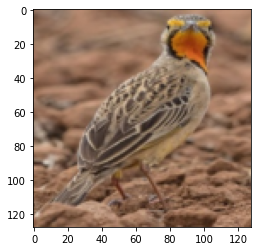

In [28]:
plt.imshow(train_set[1][0]) #128x128 seems like a good resolution feasibility and quality wise 
print(train_set[1][1]) #label verification 

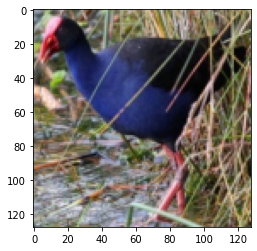

In [29]:
#here's another fun random bird 
random_int = random.randint(0, 60000)
plt.imshow(train_set[random_int][0])

# **Section 2: The Model**

In [30]:
generator_features = 128 
discriminator_features = 128 
prior_size = 100 
num_channels = 3
z_len = 100 #size of latent prior z 

In [31]:
#The following function was taken from :
#https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
#It applies the random weight initializations as specified by Goodfellow et. al. 
#2016 

def weights_initialization(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [32]:
class Generator(nn.Module):

  def __init__(self):
    super(Generator, self).__init__()
    self.block1 = nn.Sequential(
        nn.ConvTranspose2d(prior_size, generator_features * 32, 4, 2, 0, bias = False),
        nn.BatchNorm2d(generator_features*32),
        nn.ReLU(True)
    )
    
    self.block2 = nn.Sequential(
        nn.ConvTranspose2d(generator_features*32, generator_features * 16, 4, 2, 1, bias = False),
        nn.BatchNorm2d(generator_features*16),
        nn.ReLU(True)
    )
    self.block3 = nn.Sequential(
        nn.ConvTranspose2d(generator_features*16, generator_features*8, 4, 2, 1, bias = False),
        nn.BatchNorm2d(generator_features*8),
        nn.ReLU(True)
    )
    self.block4 = nn.Sequential(
        nn.ConvTranspose2d(generator_features*8, generator_features*4, 4, 2, 1, bias = False),
        nn.BatchNorm2d(generator_features*4),
        nn.ReLU(True)
    )
    self.block5 = nn.Sequential(
        nn.ConvTranspose2d(generator_features*4, generator_features*2, 4, 2, 1, bias = False),
        nn.BatchNorm2d(generator_features*2),
        nn.ReLU(True)
    )
    self.block6 = nn.Sequential(
        nn.ConvTranspose2d(generator_features*2, num_channels, 4, 2, 1, bias = False),
        nn.Tanh()
    )
  
  def forward(self, x):
    #define forward pass
    out = self.block1(x)
    out = self.block2(out)
    out = self.block3(out)
    out = self.block4(out)
    out = self.block5(out)
    out = self.block6(out)

    return out

In [33]:
from torch.nn.modules.activation import Sigmoid

from torch.nn.modules.batchnorm import BatchNorm2d
class Discriminator(nn.Module):
  
  def __init__(self):
    super(Discriminator, self).__init__()
    self.block1 = nn.Sequential(
        nn.Conv2d(num_channels, discriminator_features, 4, 2, 1, bias = False),
        nn.LeakyReLU(0.2, inplace=True)
    )
    self.block2 = nn.Sequential(
        nn.Conv2d(discriminator_features, discriminator_features * 2, 4, 2, 1, bias = False),
        nn.BatchNorm2d(discriminator_features*2),
        nn.LeakyReLU(0.2, inplace=True)
    )
    self.block3 = nn.Sequential(
        nn.Conv2d(discriminator_features *2, discriminator_features * 4, 4, 2, 1, bias = False),
        nn.BatchNorm2d(discriminator_features*4),
        nn.LeakyReLU(0.2, inplace=True)
    )
    self.block4 = nn.Sequential(
        nn.Conv2d(discriminator_features * 4, discriminator_features * 8, 4, 2, 1, bias = False),
        nn.BatchNorm2d(discriminator_features*8),
        nn.LeakyReLU(0.2, inplace=True)
    )
    self.block5 = nn.Sequential(
        nn.Conv2d(discriminator_features * 8, discriminator_features*16, 4, 2, 1, bias = False),
        nn.LeakyReLU(0.2, inplace=True) #binary classificaton task 
    )
    self.block6 = nn.Sequential(
        nn.Conv2d(discriminator_features*16, 1, 4, 2, 0, bias= False),
        nn.Sigmoid()
    )
  def forward(self, x):
    #define forward pass 
    out = self.block1(x)
    out = self.block2(out)
    out = self.block3(out)
    out = self.block4(out)
    out = self.block5(out)
    out = self.block6(out)
    out = torch.squeeze(out)

    return out

# **Section 3: The Training**

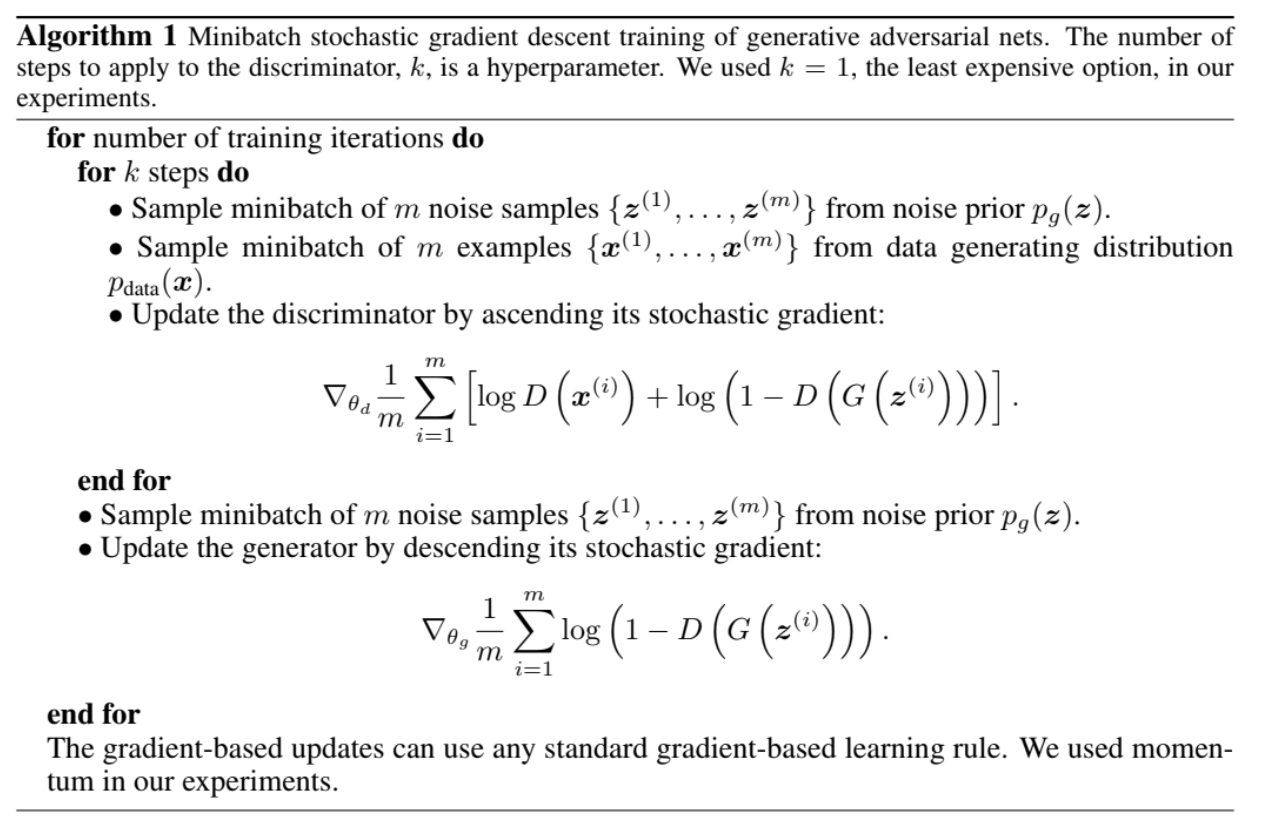

In [34]:
#def train_gen():

In [35]:
#def train_disc():

In [36]:
#high level design decision- use the same variables and repeat computation 
#wherever possible to reduce GPU RAM usage 

#Inputs: networks, criterion for loss function, optimizers, data loader, cpu/gpu
#Ouptuts: One generated output representative of training progress per epoch 
#Does: trains the discriminator and generator as implied by the algorithm above 
def trainer(net_d, net_g, criterion, optimizer_d, optimizer_g, data_loader, epochs, device):
  real = 1 
  synthetic = 0 
  net_d = net_d.to(device)
  net_g = net_g.to(device)

  test_noise = torch.randn(generator_features, z_len, 1, 1, device = device)
  test_images = []
  
  for epoch in range(epochs):
    
    print("Epoch %d / %d" % (epoch+1, epochs))
    print("-"*10)
    
    for idx, batch in enumerate(data_loader,0):

      #Start by training the Discriminator as above 
      #Update discriminator for real data 
      
      net_d.zero_grad()
      x_device = batch[0].to(device)
      #y_device = y_batch.to(device) not needed
      labels = torch.full((x_device.size(0),), real, dtype=torch.float, device=device)
      outputs = net_d(x_device).view(-1) 
      error_d_real = criterion(outputs, labels)
      error_d_real.backward()

      D_x = outputs.mean().item()

      #Generate Synthetic Data from gaussian prior 
      gaussian_prior = torch.randn(x_device.size(0), z_len, 1, 1, device = device)
      generated_data = net_g(gaussian_prior)
      
      labels= torch.full((x_device.size(0),), synthetic, dtype=torch.float, device = device)
      outputs = net_d(generated_data.detach()).view(-1) #done to avoid backprop through generator at this point 
      error_d_synthetic = criterion(outputs, labels)
      error_d_synthetic.backward()

      D_G_z = outputs.mean().item()

      error_d_cum = error_d_synthetic + error_d_real
      optimizer_d.step()

      #Switch gears to training the generator 
      net_g.zero_grad()
      outputs= net_d(generated_data).view(-1)
      labels = torch.full((x_device.size(0),), real, dtype=torch.float, device=device)
      error_g = criterion(outputs, labels)
      error_g.backward()

      D_G_z1 = outputs.mean().item()

      optimizer_g.step()

      if(idx % batch_size == 0):
            print('[%d/%d][%d/%d] Discriminator Loss: %.4f Generator Loss: %.4f D(x): %.4f D(G(z)) (True, False): %.4f , %.4f'
                  % (epoch+1, epochs, idx, len(data_loader),
                     error_d_cum.item(), error_g.item(), D_x, D_G_z, D_G_z1))
    
    with torch.no_grad():
      #Save a generated image, to see how the generator training is progressing 
      output_progress = net_g(test_noise).cpu().detach()
      test_images.append(output_progress)
  
  return test_images

In [37]:
def initialize_weights(model):
  for module in model.modules():
    if isinstance(module, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
      nn.init.normal_(module.weight.data, 0.00, 0.02)

In [38]:
gen_model = Generator()
disc_model = Discriminator()
initialize_weights(gen_model)
initialize_weights(disc_model)

criterion = nn.BCELoss()

alpha = 0.0002
optim_d = torch.optim.Adam(disc_model.parameters(), lr = alpha, betas = (0.5, 0.999))
optim_g = torch.optim.Adam(disc_model.parameters(), lr = alpha, betas = (0.5, 0.999))

epochs = 3 # start small, go from there 
batch_size = 128

train_transform = T.Compose([T.Resize((128, 128)),
                             T.ToTensor(), 
                             T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
train_set = birds_dataset(train_images, category_map, train_transform)
train_loader = DataLoader(dataset = train_set, batch_size = batch_size, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [39]:
generator_output_examples = trainer(disc_model,gen_model,criterion,optim_d, optim_g, train_loader, epochs, device)
#Need 6 blocks in both gen and disc to work for 128x128

Epoch 1 / 3
----------
[1/3][0/552] Discriminator Loss: 1.4273 Generator Loss: 1.5390 D(x): 0.4998 D(G(z)) (True, False): 0.5194 , 0.2159
[1/3][128/552] Discriminator Loss: 0.4175 Generator Loss: 1.2269 D(x): 0.9989 D(G(z)) (True, False): 0.3405 , 0.2933
[1/3][256/552] Discriminator Loss: 0.3841 Generator Loss: 1.2545 D(x): 0.9996 D(G(z)) (True, False): 0.3187 , 0.2852
[1/3][384/552] Discriminator Loss: 0.3781 Generator Loss: 1.2724 D(x): 0.9998 D(G(z)) (True, False): 0.3147 , 0.2801
[1/3][512/552] Discriminator Loss: 0.5838 Generator Loss: 1.4438 D(x): 0.9469 D(G(z)) (True, False): 0.4103 , 0.2361
Epoch 2 / 3
----------
[2/3][0/552] Discriminator Loss: 0.4178 Generator Loss: 1.2904 D(x): 0.9974 D(G(z)) (True, False): 0.3398 , 0.2752
[2/3][128/552] Discriminator Loss: 0.4041 Generator Loss: 1.2797 D(x): 0.9992 D(G(z)) (True, False): 0.3319 , 0.2781
[2/3][256/552] Discriminator Loss: 0.4049 Generator Loss: 1.2735 D(x): 0.9993 D(G(z)) (True, False): 0.3325 , 0.2798
[2/3][384/552] Discrim

In [40]:
print(len(generator_output_examples))
print(generator_output_examples[0])

3
tensor([[[[ 1.0867e-03, -4.3565e-03, -1.9255e-04,  ..., -4.5210e-03,
            5.8555e-04, -2.5540e-03],
          [ 1.2715e-03, -1.6524e-05, -3.3929e-04,  ..., -9.3677e-04,
            3.4240e-04,  2.2518e-03],
          [-2.0555e-03, -1.5398e-02, -2.9515e-03,  ..., -1.3448e-02,
           -3.6090e-03, -5.1094e-03],
          ...,
          [ 1.8957e-03,  6.0184e-03,  2.7663e-03,  ...,  1.7489e-03,
            1.0899e-03,  1.6557e-03],
          [-9.8618e-04, -1.5219e-02, -2.5550e-03,  ..., -1.0057e-02,
           -1.5349e-03, -5.0733e-03],
          [ 1.1385e-03,  1.6245e-03,  1.0220e-04,  ...,  3.2975e-04,
           -1.2521e-03,  1.5259e-03]],

         [[ 2.0938e-03, -1.8870e-03,  2.2631e-03,  ...,  1.2578e-03,
            3.8774e-03, -9.9202e-04],
          [-7.4055e-04,  1.2025e-03,  1.4281e-03,  ..., -3.9075e-04,
            8.7551e-04, -1.8358e-03],
          [ 1.2585e-03, -2.3439e-03,  3.5508e-03,  ..., -4.7418e-05,
            1.5626e-03, -1.8184e-03],
          ...,
   

# **Section 4: Generator Output Visualization**



# **Section 5: Transfer Learning this model for classification**